<a href="https://colab.research.google.com/github/begeorf/haptix_animations/blob/main/Single_link_manipulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ROB 215 Lab: Double Pendulum Solution: Symbolic Manipuation + Numerical Integration + Animation

This notebook is an exercise to put together the concepts shown to you in the last few labs, namely, symbolic manipulation, numerical integration, and animation.

Here are some packages you may find handy to import.

In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting(use_latex='mathjax')

import numpy as np
from scipy import constants
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

In [2]:
%%html
<!-- Necessary for Google Colab -->
<div style="background-color: #FFFFFF; width: max-content">
<img src="https://moorepants.github.io/learn-multibody-dynamics/_images/noncontributing-pendulum-fbd.svg">
</div>

Consider a double pendulum system as shown above. First define the nessessary variables $m_i, l_i, g, q_i, T_i$. Which are time varying? We will also define time $t$ as a Sympy object `t = me.dynamicsymbols._t`

In [3]:
m1, m2, l1, l2, g = sm.symbols('m1, m2, l1, l2, g')
q1, q2, T1, T2 = me.dynamicsymbols('q1, q2, T1, T2')
t = me.dynamicsymbols._t

Now create the frames $N, A, B$ and orient them as shown in the figure.

In [4]:
N = me.ReferenceFrame('N')
A = me.ReferenceFrame('A')

A.orient_axis(N, q1, N.z)

And create points $O, P_1, P_2$ and position them as shown in the figure.

In [5]:
O = me.Point('O')
P1 = O.locatenew('P1', l1*A.x)

The following code block sets the velocities and accelerations of each point. The velocity of $O$ is zero, as it is our origin and anchor. `.v2pt_theory()` sets the velocity of point object by determining and saving the relationship using the 2-point theory. The function documention can be found [here](https://docs.sympy.org/latest/modules/physics/vector/api/kinematics.html#sympy.physics.vector.point.Point.v2pt_theory), and a helpful discussion can be found [here](https://docs.sympy.org/latest/modules/physics/vector/kinematics.html#kinematics-in-physics-vector).

Do the velocities of $P_1$ and $P_2$ seem correct?

In [6]:
O.set_vel(N, 0)
P1.v2pt_theory(O, N, A)
P1.a2pt_theory(O, N, A)
display(P1.vel(N))

l₁⋅q₁̇ a_x

l₁⋅q₁̇ a_x + l₂⋅q₂̇ b_x

Now let's apply Newton's method. This should just be an extension of the single pendulum example from the previous lab. However, this time, we'll use Sympy to make our lives easier.

`F_P1` should be the forces acting on particle 1, and `F_P2` those acting on particle 2. I.e.
\begin{align*}
\text{F_P1} &= \sum F^{\mathrm{P1},i} \\
\text{F_P2} &= \sum F^{\mathrm{P2},i}
\end{align*}

These equations should be defined in terms of the Sympy variables and unit vectors defined earlier.

In [7]:
F_P1 = T1*A.y - T2*B.y - m1*g*N.y
F_P2 = T2*B.y - m2*g*N.y

We define variables `zero_P1` and `zero_P2` to be the rearranged equation:
\begin{align*}
0 &= \sum F - ma \\
\text{zero_P1} &= \sum F^{\mathrm{P1},i} - m_1 a^{\mathrm{P1}} \\
\text{zero_P2} &= \sum F^{\mathrm{P2},i} - m_2 a^{\mathrm{P2}}
\end{align*}

Note that we set/calculated the velocities and accelerations of $P_1, P_2$ earlier, so we can use a Sympy function to simply retrieve ${}^Na^{\mathrm{P1}}, {}^Na^{\mathrm{P2}}$

In [8]:
zero_P1 = F_P1 - m1*P1.acc(N)
zero_P2 = F_P2 - m2*P2.acc(N)

Now we have two planar vector equations. We want to write these as scalar equations and store them in a matrix `fd`.

Hint: Break the equation into components along specified directions as in the single pendulum lab example. What operation is used for vector projection?

In [9]:
fd = sm.Matrix([
    zero_P1.dot(N.x),
    zero_P1.dot(N.y),
    zero_P2.dot(N.x),
    zero_P2.dot(N.y),
])
display(fd)

⎡                                    ⎛          2     ⎞                        ↪
⎢                -l₁⋅m₁⋅cos(q₁)⋅q₁̈ - ⎝- l₁⋅m₁⋅q₁̇  + T₁⎠⋅sin(q₁) + T₂⋅sin(q₂)   ↪
⎢                                                                              ↪
⎢                                        ⎛          2     ⎞                    ↪
⎢             -g⋅m₁ - l₁⋅m₁⋅sin(q₁)⋅q₁̈ + ⎝- l₁⋅m₁⋅q₁̇  + T₁⎠⋅cos(q₁) - T₂⋅cos(q ↪
⎢                                                                              ↪
⎢                    2                                         ⎛          2    ↪
⎢    l₁⋅m₂⋅sin(q₁)⋅q₁̇  - l₁⋅m₂⋅cos(q₁)⋅q₁̈ - l₂⋅m₂⋅cos(q₂)⋅q₂̈ - ⎝- l₂⋅m₂⋅q₂̇  +  ↪
⎢                                                                              ↪
⎢                                           2                      ⎛           ↪
⎣-g⋅m₂ - l₁⋅m₂⋅sin(q₁)⋅q₁̈ - l₁⋅m₂⋅cos(q₁)⋅q₁̇  - l₂⋅m₂⋅sin(q₂)⋅q₂̈ + ⎝- l₂⋅m₂⋅q₂̇ ↪

↪                ⎤
↪                ⎥
↪                ⎥
↪                ⎥
↪ ₂)             ⎥
↪

Now we note that the scalar equations are linear in terms of the angular accelerations and forces
\begin{equation*}
\left[ \ddot{q}_1, \ddot{q}_2, T_1, T_2 \right]^T
\end{equation*}

This means that if we consider
\begin{equation*}
f_d(\left[ \ddot{q}_1, \ddot{q}_2, T_1, T_2 \right]^T): \mathbb{R}^4 \rightarrow \mathbb{R}^4
\end{equation*}
and take the jacobian `Md` = $J_{f_d}$, we will put the linear scalar equations into matrix form with no loss.

However, we're missing the terms that aren't dependent on the angular accelerations and forces. To isolate those terms, we simply substitute $\left[ \ddot{q}_1, \ddot{q}_2, T_1, T_2 \right]^T = 0$ into `fd` and save that as variable `gd`. All put together,

\begin{equation*}
0 = f_d(\left[ \ddot{q}_1, \ddot{q}_2, T_1, T_2 \right]^T) = M_d \begin{bmatrix}
\ddot{q}_1 \\ \ddot{q}_2 \\ T_1 \\ T_2
\end{bmatrix}
+ g_d
\end{equation*}

You will likely want to use
- `.jacobian()` [(doc)](https://docs.sympy.org/latest/modules/matrices/matrices.html#sympy.matrices.matrixbase.MatrixBase.jacobian)
- `.xreplace()` [(doc)](https://docs.sympy.org/latest/modules/core.html#sympy.core.basic.Basic.xreplace): Note that the input is "dict-like"
- `.diff()` [(doc)](https://docs.sympy.org/latest/modules/core.html#sympy.core.function.diff)

In [10]:
lin_vars = sm.Matrix([q1.diff(t,2), q2.diff(t,2), T1, T2])
Md = fd.jacobian(lin_vars)
gd = fd.xreplace({v: 0 for v in lin_vars})
display(lin_vars, Md, gd)

⎡q₁̈⎤
⎢  ⎥
⎢q₂̈⎥
⎢  ⎥
⎢T₁⎥
⎢  ⎥
⎣T₂⎦

⎡-l₁⋅m₁⋅cos(q₁)        0         -sin(q₁)  sin(q₂) ⎤
⎢                                                  ⎥
⎢-l₁⋅m₁⋅sin(q₁)        0         cos(q₁)   -cos(q₂)⎥
⎢                                                  ⎥
⎢-l₁⋅m₂⋅cos(q₁)  -l₂⋅m₂⋅cos(q₂)     0      -sin(q₂)⎥
⎢                                                  ⎥
⎣-l₁⋅m₂⋅sin(q₁)  -l₂⋅m₂⋅sin(q₂)     0      cos(q₂) ⎦

⎡                              2              ⎤
⎢              l₁⋅m₁⋅sin(q₁)⋅q₁̇               ⎥
⎢                                             ⎥
⎢                                  2          ⎥
⎢          -g⋅m₁ - l₁⋅m₁⋅cos(q₁)⋅q₁̇           ⎥
⎢                                             ⎥
⎢                    2                   2    ⎥
⎢    l₁⋅m₂⋅sin(q₁)⋅q₁̇  + l₂⋅m₂⋅sin(q₂)⋅q₂̇     ⎥
⎢                                             ⎥
⎢                        2                   2⎥
⎣-g⋅m₂ - l₁⋅m₂⋅cos(q₁)⋅q₁̇  - l₂⋅m₂⋅cos(q₂)⋅q₂̇ ⎦

Now we want Sympy to turn our symbolic expressions into a lambda function to quickly calculate solutions numerically. Let's identify the inputs and outputs of the function.
- Outputs: `Md` and `gd`
- Inputs: `q_states` = $\left[q_1, q_2, \dot{q_1}, \dot{q_2} \right]$ (1D vector)

But wait, we also need to define the problem parameters, so lets define
- `params` = $\left[m_1, m_2, l_1, l_2, g\right]$ (1D vector)

So, use `.lambdify()` to create a function with handle `eval_eom` that takes in `q_states` and `params` and outputs `Md` and `gd`

In [11]:
params = sm.Matrix([m1, m2, l1, l2, g])
q_states = sm.Matrix([q1, q2, q1.diff(t), q2.diff(t)])
eval_eom = sm.lambdify((q_states, params), [Md, gd])

Now we can finally implement things numerically! Here we define the actual values of the parameters.

In [12]:
m1_num = 1
m2_num = 1
l1_num = 1
l2_num = 1
param_values = np.array([m1_num, m2_num, l1_num, l2_num, constants.g])

And now we need a function $f$ such that $\dot{x} = f(t, x)$. This means:
- Input: $\left[q_1, q_2, \dot{q_1}, \dot{q_2} \right]$ (1D vector)
- Output: $\left[\dot{q_1}, \dot{q_2}, \ddot{q_1}, \ddot{q_2} \right]$ (1D vector)

Recall that `eval_eom` gives us `Md` and `gd` where

\begin{equation*}
0 = M_d \begin{bmatrix}
\ddot{q}_1 \\ \ddot{q}_2 \\ T_1 \\ T_2
\end{bmatrix}
+ g_d
\end{equation*}

You can use Numpy's `np.linalg.solve()` to solve $Ax=b$ systems. We also want to use `np.squeeze(gd)` to force `gd` to be a 1D array, which results in the solution also being 1D. Unexpected issues may arise from using a 2D vector accidentally, for example, in Matplotlib animations.

In [13]:
def ode_fun(t: np.float64, x: np.ndarray) -> np.ndarray:
    x_dot = np.zeros(x.shape)
    x_dot[:2] = x[2:]
    Md, gd = eval_eom(x, param_values)
    vars = np.linalg.solve(-Md, np.squeeze(gd))
    x_dot[2:] = vars[:2]
    return x_dot

Here we define the parameters of our simulation: initial and final time $t_0, t_f$, initial state $x_0$, and time step $dt$. Use Scipy's `solve_ivp` to solve the problem.
Use the options:
- `method='RK45'`
- `vectorized=False`
- `t_eval` set to a time array t0:dt:tf

In [14]:
t0 = 0
tf = 10
x0 = np.array([np.pi/4, -np.pi/4, 0, 0])
dt = 0.01
rk45_sol = solve_ivp(ode_fun, (t0, tf), x0, method='RK45', vectorized=False, t_eval=np.linspace(t0,tf,int((tf-t0)/dt)))

Now create a plot of the solution of the states. Does it seem reasonable?

Note that `rk45_sol.y` has shape (4,n), meaning one row for each state, and one column for each time step. You will also want to take the transpose as Matplotlib is expecting time to be along the rows and variables along the columns.

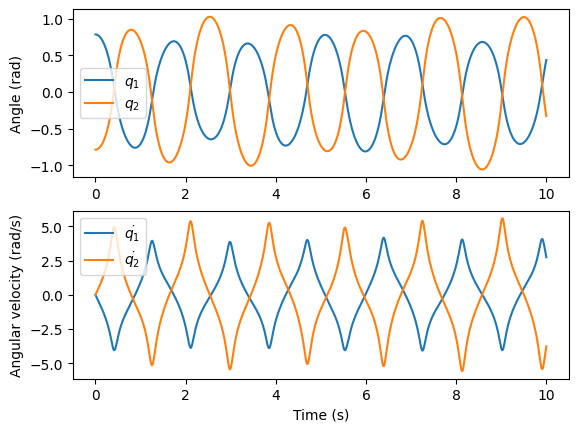

In [15]:
f1 = plt.figure()
ax1 = f1.add_subplot(2,1,1)
ax2 = f1.add_subplot(2,1,2)
ax1.plot(rk45_sol.t, rk45_sol.y[:2,:].T)
ax1.set_ylabel("Angle (rad)")
ax1.legend(["$q_1$", "$q_2$"])
ax2.plot(rk45_sol.t, rk45_sol.y[2:,:].T)
ax2.set_ylabel("Angular velocity (rad/s)")
ax2.set_xlabel("Time (s)")
ax2.legend(["$\dot{q_1}$", "$\dot{q_2}$"])
plt.show()

Now create a figure to visualize the double pendulum, and plot our initial solution. We will want to plot three points: $O, P_1, P_2$.

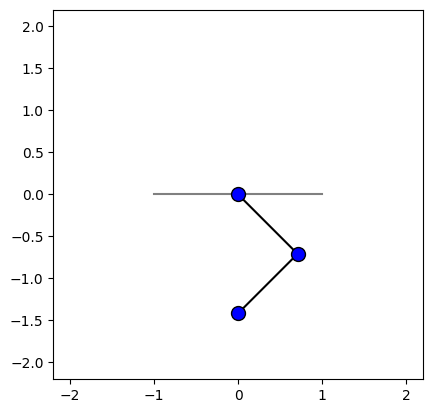

In [16]:
# location of hinge and end of rod
plot_x = [0, l1_num*np.sin(rk45_sol.y[0,0]), l1_num*np.sin(rk45_sol.y[0,0]) + l2_num*np.sin(rk45_sol.y[1,0])]
plot_y = [0, -l1_num*np.cos(rk45_sol.y[0,0]), -l1_num*np.cos(rk45_sol.y[0,0]) + -l2_num*np.cos(rk45_sol.y[1,0])]

# create a figure
f4, ax4 = plt.subplots()

# common line and marker properties for each panel
line_prop = {
    'color': 'black',
    'marker': 'o',
    'markerfacecolor': 'blue',
    'markersize': 10,
}
box_prop = {
    'marker': [(-2,1),(-2,-1),(2,-1),(2,1)],
    'markerfacecolor': 'gray',
    'markersize': 40,
    'markeredgecolor': 'gray'
}

# 2D view
ax4.plot(np.linspace(-(l1_num+l2_num)/2,(l1_num+l2_num)/2,2), np.zeros((2)), color="gray")
lines, = ax4.plot(plot_x, plot_y, **line_prop)
ax4.set_xlim(np.array([-(l1_num+l2_num), (l1_num+l2_num)])*1.1)
ax4.set_ylim(np.array([-(l1_num+l2_num), (l1_num+l2_num)])*1.1)
ax4.set_aspect('equal')

If you above figure looks correct, then you should've already figured out the positions of $O, P_1, P_2$. Now make a slight change and determine the positions when at the i-th sample.

In [17]:
def animate(i):
    plot_x = [0, l1_num*np.sin(rk45_sol.y[0,i]), l1_num*np.sin(rk45_sol.y[0,i]) + l2_num*np.sin(rk45_sol.y[1,i])]
    plot_y = [0, -l1_num*np.cos(rk45_sol.y[0,i]), -l1_num*np.cos(rk45_sol.y[0,i]) + -l2_num*np.cos(rk45_sol.y[1,i])]
    plot_x = np.squeeze(plot_x)
    plot_y = np.squeeze(plot_y)
    # data shapes must be 1D numpy vec (not list, not 2D with (X,1)) for animate
    lines.set_data(plot_x, plot_y)

The following code ensures that you aren't trying to make too many frames, as that will increase the render time.

In [18]:
n_samp = rk45_sol.y.shape[1]
fps_full = n_samp/(tf-t0)
if fps_full > 24:
  fps_play = np.min([fps_full, 24])
  ani = FuncAnimation(f4, animate, frames=np.arange(0, n_samp, fps_full/fps_play).astype(np.int64))
  # cast type after arange, avoid cascading truncation error
else:
  fps_play = fps_full
  ani = FuncAnimation(f4, animate, frames=n_samp)
HTML(ani.to_jshtml(fps=fps_play))
# google colab seems to play animation slow, fine when run locally